In [1]:
import bnlearn as bn
import matplotlib.pyplot as plt
import itertools
import numpy as np

[bnlearn] >Checking CPDs..
[bnlearn] >Check for DAG structure. Correct: True
[bnlearn] >Plot based on BayesianModel


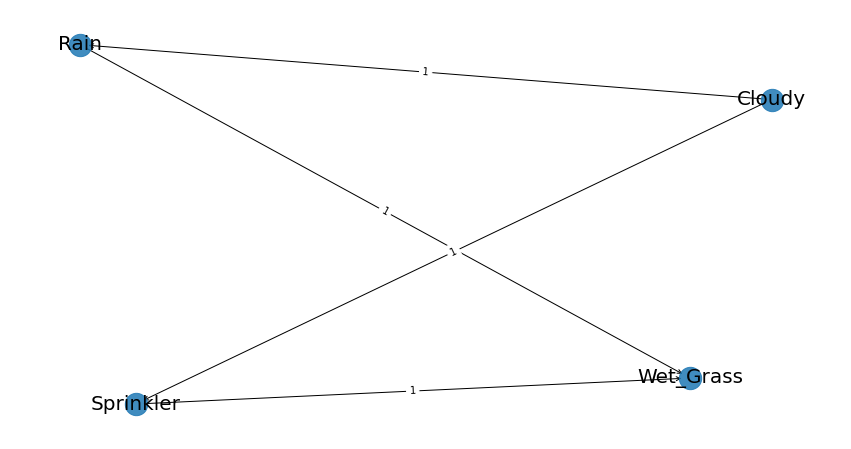

{'pos': {'Cloudy': array([0.95419468, 0.70608799]),
  'Sprinkler': array([-0.76832715, -0.92267468]),
  'Rain': array([-0.91917557,  1.        ]),
  'Wet_Grass': array([ 0.73330804, -0.78341332])},
 'G': <networkx.classes.digraph.DiGraph at 0x203f98933a0>}

In [9]:
model = bn.import_DAG('sprinkler')
bn.plot(model)

In [14]:
bn.print_CPD(model)

CPD of Cloudy:
+-----------+-----+
| Cloudy(0) | 0.5 |
+-----------+-----+
| Cloudy(1) | 0.5 |
+-----------+-----+
CPD of Sprinkler:
+--------------+-----------+-----------+
| Cloudy       | Cloudy(0) | Cloudy(1) |
+--------------+-----------+-----------+
| Sprinkler(0) | 0.5       | 0.9       |
+--------------+-----------+-----------+
| Sprinkler(1) | 0.5       | 0.1       |
+--------------+-----------+-----------+
CPD of Rain:
+---------+-----------+-----------+
| Cloudy  | Cloudy(0) | Cloudy(1) |
+---------+-----------+-----------+
| Rain(0) | 0.8       | 0.2       |
+---------+-----------+-----------+
| Rain(1) | 0.2       | 0.8       |
+---------+-----------+-----------+
CPD of Wet_Grass:
+--------------+--------------+--------------+--------------+--------------+
| Sprinkler    | Sprinkler(0) | Sprinkler(0) | Sprinkler(1) | Sprinkler(1) |
+--------------+--------------+--------------+--------------+--------------+
| Rain         | Rain(0)      | Rain(1)      | Rain(0)      | Rain

In [104]:
def forward_sampling(model, samples_num):
    samples = []
    order = bn.topological_sort(model)
    for _ in range(samples_num):
        sample = {}
        for var_name in order:
            cpd = model['model'].get_cpds(var_name)
            cpd_vars = cpd.variables
            dim = cpd.variable_card
            if len(cpd_vars) == 1:
                probs = cpd.values
            else:
                probs = [0 for _ in range(dim)]
                for i in range(dim):
                    var_vals = sample.copy()
                    var_vals[var_name] = i
                    elem = cpd.values
                    for name in cpd_vars:
                        elem = elem[var_vals[name]]
                    probs[i] = elem
            elements = [i for i in range(dim)]
            val = np.random.choice(elements, p=probs)
            sample[var_name] = val
            samples.append(sample)
    return samples

In [105]:
def inference_by_sampling(model, events, min_num = 10, max_num = 1000, interval = 10):
    # df = bn.sampling(model, n=max_num, verbose=0)
    df = forward_sampling(model, max_num)
    ps = []
    event_count = 0
    total_count = 0
    for i in range(max_num):
        happened = True
        for (name, val) in events.items():
            # if df[name][i] != val:
            if df[i][name] != val:
                happened = False
                break
        if happened:
            event_count += 1
        total_count += 1
        if (i + 1) % interval == 0:
            ps.append(event_count / total_count)
    return ps

In [47]:
def inference(model, events):
    def get_prob():
        p = 1.
        for cpd in cpds:
            cpd_vars = cpd.variables
            if len(cpd_vars) == 1:
                p *= cpd.values[events[cpd.variable]]
            else:
                elem = cpd.values
                for var_name in cpd_vars:
                    elem = elem[events[var_name]]
                p *= elem
        return p
       
    cpds = model['model'].get_cpds()
    vars_num = len(cpds)
    vars_to_iterate_names = []
    vars_to_iterate = []
    p_res = 0. 
    for cpd in cpds:
        if not(cpd.variable in events):
            vars_to_iterate_names.append(cpd.variable)
            vars_to_iterate.append([i for i in range(cpd.variable_card)])
    vars_perms = list(itertools.product(*vars_to_iterate))
    for vars_perm in vars_perms:
        for i in range(len(vars_to_iterate_names)):
            events[vars_to_iterate_names[i]] = vars_perm[i]
        p_res += get_prob()
    return p_res

In [77]:
min_num=10
max_num = 50000
interval=100
events = {'Cloudy':1, 'Wet_Grass':0}

In [107]:
ps = inference_by_sampling(model, events, min_num, max_num, interval)
# ps = inference_by_sampling(model, events, 10, 50, 10)

In [73]:
prob = inference(model, events.copy())

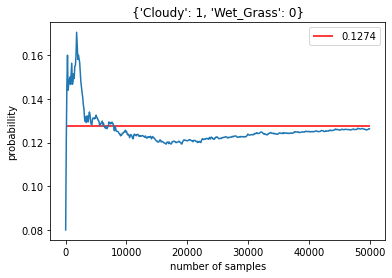

In [108]:
plt.xlabel('number of samples')
plt.ylabel('probabillity')
plt.title(str(events))
plt.plot([i for i in range(min_num, max_num+1, interval)], ps)
plt.hlines(prob, min_num, max_num, 'r', label=str(prob))
plt.legend()
plt.show()